In [59]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, List
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_tavily import TavilySearch
import os 
from dotenv import load_dotenv
import getpass
import os
import requests
import base64

load_dotenv()

FREEPIK_API_KEY = os.environ.get('FREEPIK_API_KEY')
TAVIL_API_KEY = os.environ.get('TAVILY_API_KEY')

In [78]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    google_api_key=os.environ["GEMINI_API_KEY"]
)
search_tool = TavilySearch(max_results=3,topic="news",search_depth="advanced")


In [ ]:
class AgentState(TypedDict):
    user_search_request: str
    query_type: str
    search_queries: List[str]
    summarize_queries: List[dict]
    final_report: List[dict]
    prompt: str
    img_data: List[dict]
    
def classify_query(state:AgentState) -> AgentState:
    prompt = f"""
    Classify the following query into one of the following types:
    - factual
    - trending_news
    - opinion
    - comparison
    - technical

    Query: {state['user_search_request']}

    """
    response = llm.invoke(prompt)
    state['query_type'] = response.content.strip().lower()
    return state


def split_topic(state: AgentState) -> AgentState:
    topic = state['user_search_request']
    
    if topic.endswith('?') or topic.lower().startswith(('what', 'how', 'why', 'when')):
        state['search_queries'] = [topic]
        return state
    

    split_prompt = f"""
    Break the following topic into 3 to 5 concise and distinct research sub-questions.
    
    Only return a plain list of questions, with no explanation, no formatting, and no numbering. Just one question per line.
    
    Topic: {topic}
    
    Sub-questions:
    """
    result = llm.invoke(split_prompt)
    subq_text = result.content
    subquestions = [line.strip() for line in subq_text.splitlines() if line.strip()]
    state['search_queries'] = subquestions
    return state


def search_node(state: AgentState) -> AgentState:
    queries = state['search_queries']
    query_response = []
    for i in queries:
        query_response.append(search_tool.invoke(i))
    
    state['summarize_queries'] = query_response
    return state


def summarize_node(state: AgentState) -> AgentState:
    summary = []
    for item in state['summarize_queries']:
        question = item['query']
        sources = item.get('results',[])
        source_text = '\n\n'.join(f"- {s['content']} ({s['url']})" for s in sources if s.get('content'))
        
        sum_prompt = f"""
        You are a skilled and creative content writer. Using the information provided below from multiple sources, write a well-structured, engaging, and informative article of approximately 600 to 800 words.

        Your writing should be original, thoughtful, and reader-friendly — not just a summary. Make sure to logically organize the content, include interesting insights, and synthesize facts into a smooth narrative that educates and holds the reader’s attention.

        Avoid copying text directly. Paraphrase where necessary, and maintain a professional but accessible tone.

        ### Topic:
        {question}

        ### Source Material:
        {source_text}

        ### Begin writing the article below:
        """
        response = llm.invoke(sum_prompt)
        summary.append(
            {
                'question': question,
                'summary': response.content.strip()
            }
        )

    state['final_report'] = summary
    return state


def img_prompter(state: AgentState) -> AgentState:
    context = state['final_report']
    img_prompt = f"""
    Based on the following description, write a single detailed image generation prompt in a **cinematic and cartoonish style**, suitable for models like Flux, Stable Diffusion, and Midjourney.
    
    Do not include any explanation or formatting — only return the final prompt text.
    
    Description:
    {context}
    """

    response = llm.invoke(img_prompt)
    
    state['prompt'] = response.content.strip()
    return state


def img_generator(state: AgentState) -> AgentState:
    url = "https://api.freepik.com/v1/ai/text-to-image"
    freepik_imgjson_req = {
        "prompt": state['prompt'],
        "seed": 42,
        "num_images": 1,
        "image": {"size": "square_1_1"},
    }
    headers = {
        "x-freepik-api-key": FREEPIK_API_KEY,
        "Content-Type": "application/json"
    }

    response = requests.post(url, json=freepik_imgjson_req, headers=headers)
    
    if response.status_code == 200:
        data = response.json()
        base64_image = data.get("data", [{}])[0].get("base64")

        if base64_image:
            # Decode base64 and save image
            image_path = "generated_image.jpg"
            with open(image_path, "wb") as f:
                f.write(base64.b64decode(base64_image))
            
            state['img_data'] = {
                "file_path": os.path.abspath(image_path),
                "status": "saved"
            }
        else:
            state['img_data'] = {"status": "no_base64_returned"}

    else:
        state['img_data'] = {
            "status": "error",
            "code": response.status_code,
            "message": response.text
        }

    return state
    

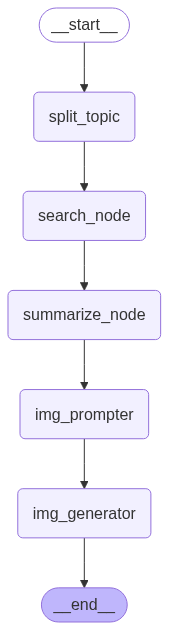

In [ ]:
graph = StateGraph(AgentState)

graph.add_node('split_topic',split_topic)
graph.add_node('search_node',search_node)
graph.add_node('summarize_node',summarize_node)
graph.add_node('img_prompter',img_prompter)
graph.add_node('img_generator',img_generator)


graph.add_edge(START, 'split_topic')
graph.add_edge('split_topic', 'search_node')
graph.add_edge('search_node', 'summarize_node')
graph.add_edge('summarize_node', 'img_prompter')
graph.add_edge('img_prompter', 'img_generator')
graph.add_edge('img_generator', END)

graph.compile()

In [85]:
app = graph.compile()
rest = app.invoke({'user_search_request': "Tamil Actor Vijay TVk Leader latest update"})

In [86]:
print(rest['final_report'][0]['summary'])

## Vijay's Political Trajectory in Tamil Nadu: An Overview

While the realm of Indian cinema often intertwines with politics, the case of Tamil actor Vijay, known mononymously, presents a particularly intriguing narrative. As one of the most popular figures in Tamil Nadu, Vijay's potential political influence has been a subject of considerable speculation and growing public attention. While concrete details about his immediate political activities remain somewhat limited in the provided material, we can piece together a picture of his evolving role and the broader political landscape in Tamil Nadu.

It's important to first acknowledge that the provided source material is a mixed bag, ranging from unrelated news snippets to brief mentions of Tamil Nadu's current Chief Minister, M.K. Stalin. Therefore, drawing definitive conclusions about Vijay's precise political involvement requires careful interpretation and contextualization. However, the very fact that his name surfaces within a new